In [1]:
import pandas as pd

ods = (
    pd.read_excel(
        "../../DB AF Completo 1.ods",
    )
    .loc[:, ["ID", "Phenotype", "Low Voltage / Scar area", "Rhythm during Mapping"]]
    .rename(
        columns={
            "ID": "Patient ID",
            "Low Voltage / Scar area": "Substrate",
            "Rhythm during Mapping": "Rhythm",
        }
    )
    .dropna(axis=0, how="any")
    .astype({"Patient ID": int})
)
csv = (
    pd.read_csv("lase.csv", sep=",")
    .dropna(axis=0, how="any")
    .astype({"Patient ID": int})
)
display(ods)
csv

,Patient ID,Phenotype,Substrate,Rhythm
3,9,Persistent,Abnormal,AF
4,10,Paroxysmal,Normal,SR
5,11,Persistent,Normal,AF
6,12,Persistent,Abnormal,SR
7,13,Persistent,Abnormal,AF
...,...,...,...,...
171,154,Parossistica,Normale,RS
177,160,Parossistica,Normale,RS
178,161,Parossistica,Normale,RS
179,162,Parossistica,Normale,RS


,Patient ID,Entropy,LASE
3,100,0,2.205838
4,101,0,1.328165
5,102,0,1.093049
6,103,0,1.873493
7,104,0,1.983513
...,...,...,...
95,94,0,1.994467
96,95,0,1.387183
97,96,0,1.947167
98,97,0,1.720367


In [2]:
# Join the two dataframes on the "ID" column
merged_df = pd.merge(
    ods.loc[:, ["Patient ID", "Phenotype", "Substrate", "Rhythm"]],
    csv,
    on="Patient ID",
    how="inner",
)

phenotype_mapping = {
    "Long standing persistent": "Persistente",
    "Persistente": "Persistente",
    "Parossistica": "Parossistica",
    "Parossistico": "Parossistica",
}

substrate_mapping = {
    "Normale": "Normale",
    "Abnormal": "Anormale",
    "Patologia": "Anormale",
    "Patologia ": "Anormale",
    "Patologia altri distretti": "Anormale",
    "Patologia parete posteriore": "Anormale",
    "Patologia parete posteriore e anteriore": "Anormale",
    "Patologia posteriore + altri": "Anormale",
    "Patologia posteriore e+ altri": "Anormale",
}

rhythm_mapping = {
    "AF": "FA",
    "FA": "FA",
    "SR": "RS",
    "RS": "RS",
}

merged_df["Phenotype"] = merged_df["Phenotype"].map(phenotype_mapping)
merged_df["Substrate"] = merged_df["Substrate"].map(substrate_mapping)
merged_df["Rhythm"] = merged_df["Rhythm"].map(rhythm_mapping)

merged_df

,Patient ID,Phenotype,Substrate,Rhythm,Entropy,LASE
0,40,Parossistica,Anormale,RS,0,1.798542
1,41,Parossistica,Normale,RS,0,2.042049
2,42,Parossistica,Normale,RS,0,1.240099
3,43,Persistente,Anormale,FA,0,1.247075
4,45,Persistente,Anormale,FA,0,1.471779
...,...,...,...,...,...,...
87,147,Parossistica,Normale,RS,0,1.774546
88,148,Parossistica,Normale,RS,0,1.606745
89,149,Parossistica,Normale,RS,0,1.121666
90,150,Parossistica,Normale,RS,0,2.212199


T-statistic: 5.88, P-value: 0.00
AUC: 0.82


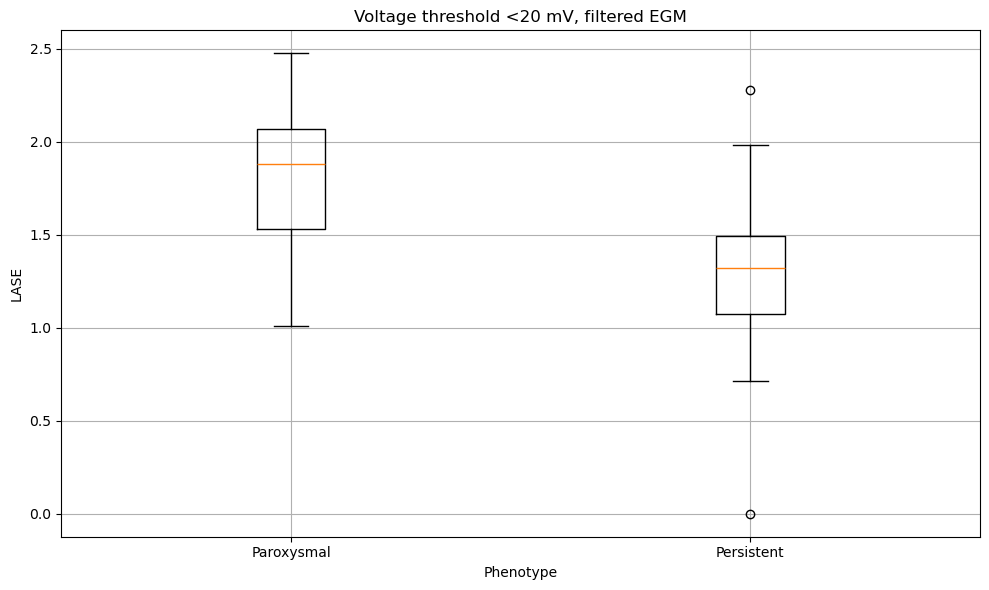

In [3]:
from scipy.stats import ttest_ind
from sklearn.metrics import roc_auc_score

# Perform t-test
paroxysmal_lase = merged_df[merged_df["Phenotype"] == "Parossistica"]["LASE"]
persistent_lase = merged_df[merged_df["Phenotype"] == "Persistente"]["LASE"]

t_stat, p_value = ttest_ind(
    paroxysmal_lase, persistent_lase, equal_var=False, alternative="greater"
)
print(f"T-statistic: {t_stat:.2f}, P-value: {p_value:.2f}")

# Calculate AUC
y = merged_df["LASE"]
y_true = merged_df["Phenotype"].apply(lambda x: 1 if x == "Parossistica" else 0)
y_pred = merged_df["LASE"]
auc = roc_auc_score(y_true, y_pred)
print(f"AUC: {auc:.2f}")

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.boxplot(
    [
        merged_df[merged_df["Phenotype"] == "Parossistica"]["LASE"],
        merged_df[merged_df["Phenotype"] == "Persistente"]["LASE"],
    ],
    tick_labels=["Paroxysmal", "Persistent"],
)
plt.title("Voltage threshold <20 mV, filtered EGM")
plt.ylabel("LASE")
plt.xlabel("Phenotype")
plt.grid()
plt.savefig("phenotype_boxplot.png", dpi=300, bbox_inches="tight")
plt.tight_layout()
plt.show()

T-statistic: -5.33, P-value: 0.00
AUC: 0.80


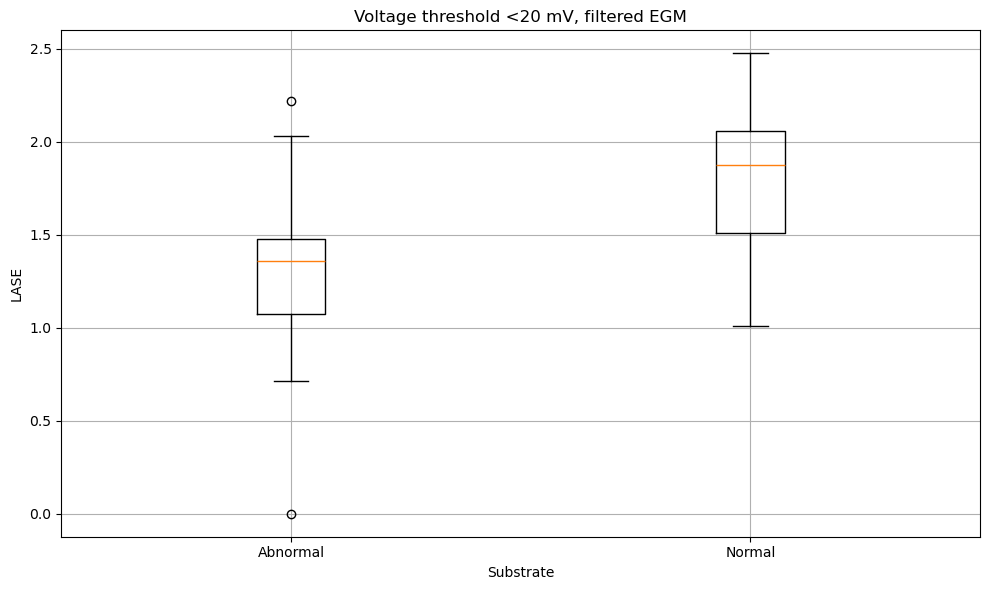

In [4]:
from scipy.stats import ttest_ind
from sklearn.metrics import roc_auc_score

# Perform t-test
abnormal_lase = merged_df[merged_df["Substrate"] == "Anormale"]["LASE"]
normal_lase = merged_df[merged_df["Substrate"] == "Normale"]["LASE"]
t_stat, p_value = ttest_ind(
    abnormal_lase, normal_lase, equal_var=False, alternative="less"
)
print(f"T-statistic: {t_stat:.2f}, P-value: {p_value:.2f}")

# Calculate AUC
y = merged_df["LASE"]
y_true = merged_df["Substrate"].apply(lambda x: 0 if x == "Anormale" else 1)
y_pred = merged_df["LASE"]
auc = roc_auc_score(y_true, y_pred)
print(f"AUC: {auc:.2f}")

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.boxplot(
    [
        merged_df[merged_df["Substrate"] == "Anormale"]["LASE"],
        merged_df[merged_df["Substrate"] == "Normale"]["LASE"],
    ],
    tick_labels=["Abnormal", "Normal"],
)
plt.title("Voltage threshold <20 mV, filtered EGM")
plt.ylabel("LASE")
plt.xlabel("Substrate")
plt.grid()
plt.savefig("substrate_boxplot.png", dpi=300, bbox_inches="tight")
plt.tight_layout()
plt.show()

T-statistic: 5.31, P-value: 0.00
AUC: 0.80


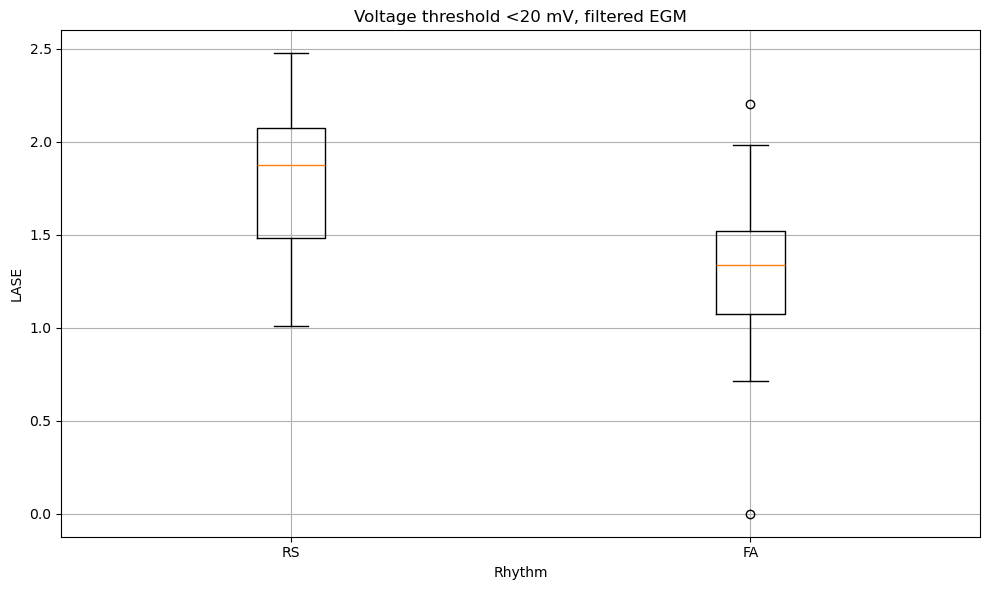

In [5]:
from scipy.stats import ttest_ind
from sklearn.metrics import roc_auc_score

# Perform t-test
sinus_lase = merged_df[merged_df["Rhythm"] == "RS"]["LASE"]
fibril_lase = merged_df[merged_df["Rhythm"] == "FA"]["LASE"]
t_stat, p_value = ttest_ind(
    sinus_lase, fibril_lase, equal_var=False, alternative="greater"
)
print(f"T-statistic: {t_stat:.2f}, P-value: {p_value:.2f}")

# Calculate AUC
y = merged_df["LASE"]
y_true = merged_df["Rhythm"].apply(lambda x: 0 if x == "FA" else 1)
y_pred = merged_df["LASE"]
auc = roc_auc_score(y_true, y_pred)
print(f"AUC: {auc:.2f}")

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.boxplot(
    [
        merged_df[merged_df["Rhythm"] == "RS"]["LASE"],
        merged_df[merged_df["Rhythm"] == "FA"]["LASE"],
    ],
    tick_labels=["RS", "FA"],
)
plt.title("Voltage threshold <20 mV, filtered EGM")
plt.ylabel("LASE")
plt.xlabel("Rhythm")
plt.grid()
plt.savefig("rhythm_boxplot.png", dpi=300, bbox_inches="tight")
plt.tight_layout()
plt.show()